# Kmeans:
Supervised learning algorithm parititions data into k clusters. The cost is the squared distance (WSS-Within Sum of Squares) between all points to their closest cluster center. 

## Initialization:
    1. Forgy Initialization: easy to implement; could lead to very different clusters
    2. Random Partition Method: more likely to stuck in local optimum
    3. kmeans++: recommended
    
## Processing:
    1. Randomly choose points as centroids
    2. Repeat until convergence:
        - For every point, assign it to the nearest cluster whose mean has the least squared euclidean distance from the point.
        - Calculate new means to be the centroids of the observation in the new clusters.
        
Weakness:
    1. Need to specify k. No global theoritical to find optimal k.
    2. Sensitive to initial centroids selection. Could have different clustering results and stuck in local optimum using Forgy initialization. Could repeat several times to pick the one with lowest cost or use k++.
    3. Can only handle numerical data by one hot encoding.
    4. Sensitive to outliers and noise. Should probably eliminate outliers beforehand and normalize all features (StandarScaler).
    5. Cannot handle non-globular clusters or clusters of different sizes and densities
    
    
## Stop condition:
    - (stability) centroids of new cluster do not change
    - (convergence) points stay in the same cluster
    - (cap) Maximum number of iterations has been reached as complexity of training is high
    
## Complexity
k (number of cllusters); I (number of iterations); N(sample size); M(dimension of each obs)
    - Training BigO: K*I*N*M
    - Prediction BigO: K*N*M

In [5]:
import numpy as np

In [101]:
def forgy_initialization(X, k):
    '''choosing any k points randomly (probably to be near the modes). 
    Could run K-means multiple times to find the global optimum'''
    return X[np.random.choice(range(X.shape[0]), replace=False, size=k),:]

def random_partition(X, k):
    '''randomly partitioning every points, and take average per partition to be the initial points.
    (close to global mean). Kmeans is more likely to get stuck in local optimum'''
    indices = np.random.choice(range(0,k), replace=True, size=X.shape[0])
    mean = []
    for partition_id in range(k):
        mean.append(X[indices==partition_id].mean(axis=0))

    return np.concatenate([val[None, :] for val in mean], axis =0)


def dist(data, centers):
    # np array broadcasting calculate distance for each point to each center.
    # data n*m, centers ki*m, data[:,None,:] n*1*m, subtraction results n*ki*m, sum long axis=2 results n*ki
    distance = np.sum((np.array(centers) - data[:,None, :])**2, axis=2)
    return distance

def kmeans_plus_plus(X, k, pdf_method=True):
    '''Initialize one point at random. Loop for k-1 interations:
    Calculate for each point the distance of the point from its nearest center.
    Sample a point with probability proportional to the square of the distance.'''
    centers = []
    X = np.array(X)
    n = X.shape[0]
    
    intial_index = np.random.choice(range(n))
    centers.append(X[initial_index])
    
    for i in range(k-1):
        distance = dist(X, centers)
        if i==0:
            pdf = distance /np.sum(distance)
            nxt_index = np.random.choice(range(n), size=1, replace = False, p = pdf.flatten())[0]
            centroid_new = X[nxt_index]
        else:
            dist_min = np.min(distance, axis=1)
            if pdf_method:
                pdf = dist_min / np.sum(dist_min)
                nxt_index = np.random.choice(range(n), size=1, replace = False, p = pdf)[0]
                centroid_new = X[nxt_index]
            else:
                nxt_index = np.argmax(dist_min, axis = 0)
                centroid_new = X[nxt_index]
                
        centers.append(centroid_new)
        
    return np.array(centers)

In [264]:
class Kmeans():
    def __init__(self, k, max_iter=300):
        self.k = k
        self.max_iter = max_iter
        
    def _forgy_initialization(self, X):
        return X[np.random.choice(range(X.shape[0]), replace=False, size=self.k),:]
    
    def _create_clusters(self, X, centroids):
        clusters = [[] for _ in range(self.k)] 
        labels = []
        for i, sample in enumerate(X):
            # centroid dim: (k)
            euclidean_dist_with_centroids = np.sqrt(np.sum(((centroids - sample)**2), axis=1))
            closest_centroid = np.argmin(euclidean_dist_with_centroids)
            labels.append(closest_centroid)
            clusters[closest_centroid].append(sample)
        # cluster is a list of unqueal length
        for i in range(self.k):
            centroids[i] = np.mean( np.array(clusters[i]), axis=0)
        return centroids, labels
    
    def fit(self, X):
        centroids = self._forgy_initialization(X)
        for _ in range(self.max_iter):
            prev_centroids = centroids
            centroids, labels = self._create_clusters(X, centroids)
            diff =  centroids - prev_centroids
            if not diff.any():
                self.centroids = centroids
                self.labels = labels
                print("convergence achieved")
                break

# Test on Sklearn Iris dats

In [256]:
from sklearn.datasets import load_iris
import seaborn as sns
X, y = load_iris(return_X_y=True)

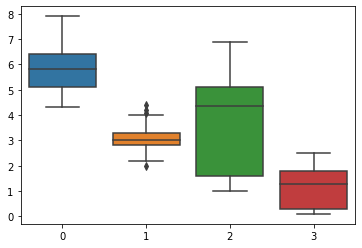

In [251]:
sns.boxplot(data=X)

The plot shows that all features are in different scale, so we should normalize the features before applying clustering

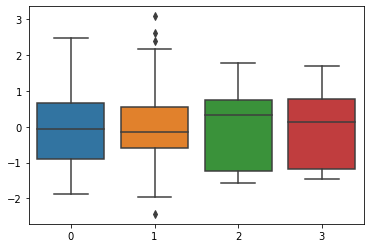

In [257]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
sns.boxplot(data=X)

## Elbow's method plot

In [370]:
from scipy.spatial.distance import cdist

K = range(2, 7)
avg_distance_centroid = []
for  k in K:
    k_means = Kmeans(k)
    k_means.fit(X)
    #avg_dis_centroid = np.min( np.sum((X[:,None,:] - k_means.centroids)**2, axis=2), axis=1).mean()
    avg_dis_centroid = np.min(cdist(X, k_means.centroids, 'euclidean'),axis=1).mean()
    avg_distance_centroid.append(avg_dis_centroid)

convergence achieved
convergence achieved
convergence achieved
convergence achieved
convergence achieved


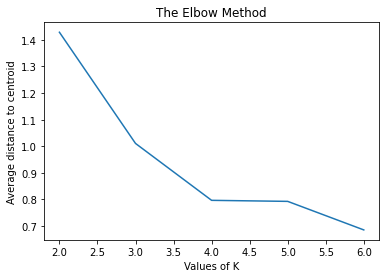

In [372]:
plt.plot(K, avg_distance_centroid) 
plt.xlabel('Values of K') 
plt.ylabel('Average distance to centroid') 
plt.title('The Elbow Method') 
plt.show() 

Mini batch k-means: https://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf